<a href="https://colab.research.google.com/github/lucas-fpaiva/tcc_pes/blob/main/piloto/notebookraul_Piloto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entendendo o problema de predição de saude da aeronave

Objetivos:

* Separar duas aeronaves para o teste final 
* Selecionar duas das séries para analisar dentro das aeronaves de treino
* Visualizar e realizar o preprocessamento dos dados
* Aplicar um modelo de predição usando uma para treinar e outra para testar

In [ ]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import plotly as py
import matplotlib.gridspec as gridspec



In [ ]:
print("Estou rodando no Colab (S/N)?")
ambiente = input()
ambiente=ambiente.upper()

if ambiente == "S":
  from google.colab import drive
  import os

  drive.mount('/content/drive',force_remount=True)
  os.chdir('/content/drive/Shareddrives/TCC_PES/codigos/Piloto')

Estou rodando no Colab (S/N)?
S
Mounted at /content/drive


## Importando os dados e selecionando uma série

### Importação dos dados

In [ ]:
#importando direto do github
data_feat = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/data/caracteristica.csv')
data_health = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/data/saude.csv')

### Separação de duas aeronaves para o teste final

In [ ]:
np.random.seed(123)
np.random.randint(0,2,10)
teste = np.random.choice(np.unique(data_health.COD_AENV),2)
print("Aviões usados para teste: ", teste)

data_health  = data_health[data_health.COD_AENV != teste[0]][data_health.COD_AENV != teste[1]]

data_feat = data_feat[data_feat.COD_AENV != teste[0]][data_feat.COD_AENV != teste[1]]

print("Aviões usados para teste: ", np.unique(data_health.COD_AENV))



Aviões usados para teste:  [9834 9747]
Aviões usados para teste:  [1011 9486 9526 9636 9664 9678 9770 9793]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [ ]:
data_health = data_health.groupby(by=['COD_FALH','COD_AENV','DT_PROC']).median().reset_index()
data_feat = data_feat.groupby(by=['COD_FALH','COD_AENV','COD_EVNT']).median().reset_index()


data_health['id']=data_health.index
data_health.head()
data = pd.merge(data_feat, data_health, on=['COD_EVNT','COD_FALH','COD_AENV']).sort_values('DT_PROC')
data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:1218: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


,COD_FALH,COD_AENV,COD_EVNT,COD_CARAC_NOM,VLR_CARAC,DT_PROC,VLR_DESG,id
3471,23,1011,116846,72.0,0.809445,2010-01-11,56.136860,6702
10389,35,1011,116846,63.0,0.000000,2010-01-11,4.396998,20114
6929,24,1011,116846,72.0,0.418330,2010-01-11,56.621538,13408
9906,24,9793,116311,72.0,0.000000,2010-01-11,60.415650,19291
6447,23,9793,116311,72.0,0.539028,2010-01-11,66.982252,12585


### Vizualização das séries

In [ ]:
# Vizualizando a Falha 23

px.line(data[data.COD_FALH==23], x='DT_PROC', y='VLR_DESG', color='COD_AENV')

In [ ]:
# Vizualizando a Falha 35
px.line(data[data.COD_FALH==35], x='DT_PROC', y='VLR_DESG', color='COD_AENV')

In [ ]:
px.line(data[data.COD_FALH==35], x='DT_PROC', y='VLR_CARAC', color='COD_AENV')

### Selecionando as aeronaves 1011 e 9486 com falha 35 para treino e teste, respectivamente

In [ ]:
f35_treino = data[(data.COD_AENV==1011) & (data.COD_FALH==35)]
f35_teste = data[(data.COD_AENV==9486)  & (data.COD_FALH==35)]

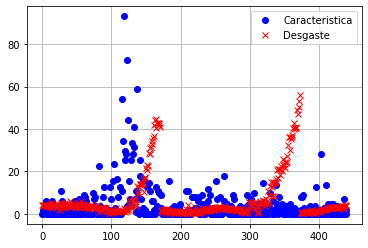

In [ ]:
# Vizualizando a Falha 35 desgaste e caracteristica
desgaste = f35_treino.VLR_CARAC.values
carac = f35_treino.VLR_DESG.values
plt.plot(desgaste,'ob',label='Caracteristica')
plt.plot(carac,'xr',label='Desgaste')
plt.legend()
plt.grid()

## Preparação dos dados para treino do modelo

* Identificação quebras na série
* Divisão da série em trechos úteis 
* Janelamento dos trechos em entradas e saídas